In [2]:
# Imports

import sys
sys.path.append("../")
import numpy
import matplotlib
import matplotlib.ticker
from tensorflow import keras

from classes.modelWrapperClass import ModelWrapper
from classes.dataLoaderClass import DataLoader
from classes.linearFitClass import LinearFit
from classes.plottingClass import Plotting
from classes.clusterClass import Cluster

#Interactive matplotlib plots
%matplotlib widget

In [25]:
# Initialisation

modelAPI = ModelWrapper(keras.models.load_model("./models/3D/M1", compile=False))
modelAPI.model.summary()
data_loader = DataLoader("./data")

noisy = data_loader.getBatch(experimental=True, noisy=True, preprocessed=True)
noisy_with_E = data_loader.getBatch(experimental=True, noisy=True, preprocessed=False)
clean = data_loader.getBatch(experimental=True, noisy=False, preprocessed=True)
names = data_loader.getX17Names()

X17_noisy = data_loader.getBatch(True, True, preprocessed=True)[100:]	# Events 0-100 are used for event generator calibration and other stuff, so these are excluded from validation data
X17_noisy_with_E = data_loader.getBatch(True, True, preprocessed=False)[100:]
X17_nonNN = data_loader.getBatch(True,False)[100:]
X17_names = data_loader.getX17Names()[100:]
X17_reconstructions = modelAPI.evaluateBatch(X17_noisy)

calib_noisy = data_loader.getBatch(True, True, preprocessed=False)[:100]
calib_noisy_with_E = data_loader.getBatch(True, True, preprocessed=False)[:100]
calib_nonNN = data_loader.getBatch(True,False, preprocessed=False)[:100]
calib_names = data_loader.getX17Names()[:100]
calib_reconstructions = modelAPI.evaluateBatch(calib_noisy)

cmap = matplotlib.pyplot.get_cmap("Greys")
cmap.set_under('cyan')

def upsample(event):
	return numpy.repeat(numpy.repeat(event, 10, axis=0), 10, axis=1)[:100,:120,:200]	# for accurate visualisation

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 14, 208  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv3d_6 (Conv3D)              (None, 12, 14, 208,  56          ['input_1[0][0]']                
                                 2)                                                               
                                                                                                  
 average_pooling3d_3 (AveragePo  (None, 12, 14, 104,  0          ['conv3d_6[0][0]']               
 oling3D)                        2)                                                           

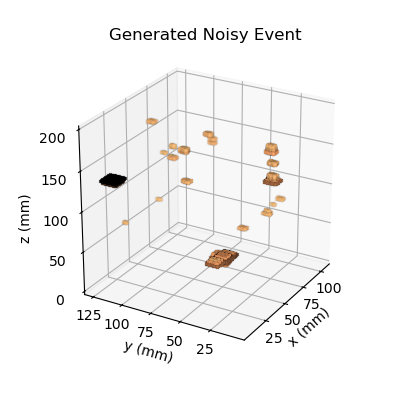

In [7]:
# View generated data
is_noisy = True

events = data_loader.getBatch(False, is_noisy, 0, preprocessed=False)
index = numpy.random.randint(0, events.shape[0])

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = Plotting.plot3D(events[index], "Generated Noisy Event", elev=25, azimuth=-150)
ax.set_box_aspect((1, 1, 1))
ax.set_xticks([25,50,75,100])
ax.set_yticks([25,50,75,100,125])
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('z (mm)', rotation=90)
fig.set_size_inches(4,4)
matplotlib.pyplot.show()

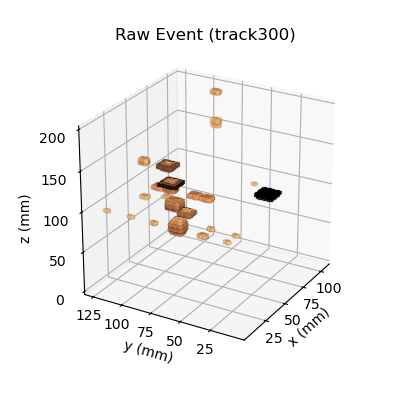

In [13]:
# View measured data

index = numpy.random.choice(DataLoader.nice_track_indices)	# nice_track_indices contains mainly interesting events. Otherwise, just numpy.random.choice from 0 to 641 is also available

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = Plotting.plot3D(data_loader.getBatch(True,True,preprocessed=False)[index], "Raw Event (track" + str(index+1) + ")", eps=1e-13, elev=25, azimuth=-150, z_cut=(0,200))
ax.set_box_aspect((1, 1, 1))
ax.set_xticks([25,50,75,100])
ax.set_yticks([25,50,75,100,125])
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('z (mm)', rotation=90)
fig.set_size_inches(4,4)
matplotlib.pyplot.show()

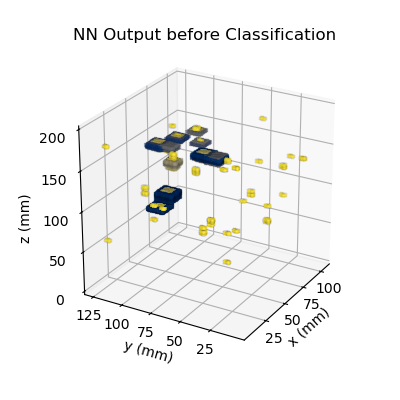

In [20]:
# Show reconstruction
index = numpy.random.choice(DataLoader.nice_track_indices)

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)


#fig, ax = Plotting.plot3D(X17_nonNN[index-100], "Conventional algorithm", eps=0, elev=25, azimuth=-150)
fig, ax = Plotting.plot3D( numpy.where(X17_noisy[index-100]>0, X17_reconstructions[index-100], 0), "NN Output before Classification", eps=0, elev=25, azimuth=-150, cmap="cividis_r")
#fig, ax = Plotting.plot3D(numpy.where(X17_reconstructions[index-100]>0.42,X17_noisy[index-100],0), r"NN Output after Classification ($\tau=0.42$)", elev=25, azimuth=-150)
ax.set_box_aspect((1, 1, 1))
ax.set_xticks([25,50,75,100])
ax.set_yticks([25,50,75,100,125])
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('z (mm)', rotation=90)

fig.set_size_inches(4,4)
matplotlib.pyplot.show()

In [29]:
# Set classification threshold tau

modelAPI.threshold = 0.42
X17_classified = modelAPI.classify(X17_reconstructions)

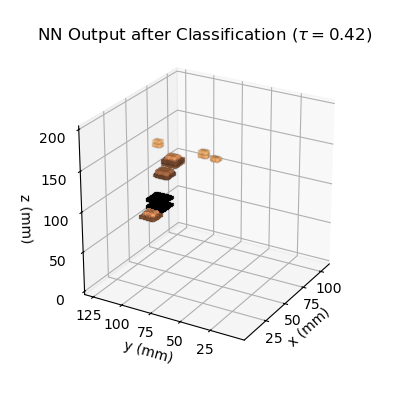

In [34]:
# Crosstalk example

crosstalk_indices = [103, 124, 139, 158, 174, 207, 225, 278, 299, 336, 340, 398, 432, 499, 511, 515, 522, 528, 591, 596, 620, 621]	# Visually found
index = numpy.random.choice(crosstalk_indices)

noisy_event = noisy_with_E[index]
preprocessed_event = noisy[index]
nonNN_reconstruction = numpy.where( clean[index] > 1e-6, 1, 0)
NN_raw_reconstruction = modelAPI.evaluateSingleEvent(preprocessed_event)
NN_classification = modelAPI.classify(NN_raw_reconstruction) 
def upsample(event):
	return numpy.repeat(numpy.repeat( numpy.copy(event) , 10, axis=0), 11, axis=1)[:100,:120,:200]
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = Plotting.plot3D(numpy.where(X17_reconstructions[index-100]>0.42,X17_noisy[index-100],0), r"NN Output after Classification ($\tau=0.42$)", elev=25, azimuth=-150)
ax.set_box_aspect((1, 1, 1))
ax.set_xticks([25,50,75,100])
ax.set_yticks([25,50,75,100,125])

fig.set_size_inches(4,4)	#4,5
matplotlib.pyplot.show()

In [35]:
# Compare recognition with ground truth

def parseGroundTruthLine(line :str) -> tuple[str, int]:
	index = line.find("	")
	name = line[:index-1]
	line = line[index+1:]
	label_hugo = int( line[:index] )
	return (name, label_hugo)

def compareGroundTruth(events :numpy.ndarray, goodCriterionFunction, skip_calibration :bool = True) -> tuple[int, list[int], list[int], list[int]]:
	num_tracks, found_tracks, unfound_tracks, false_positives = 0, [], [], []

	with open("./labels.txt", 'r') as f:
		f.readline()	# skip the heading

		if skip_calibration:
			for _ in range(100):
				f.readline()
		
		i = 0
		for line in f.readlines():
			name, label_hugo = parseGroundTruthLine(line)
			if goodCriterionFunction(events[i]):
				if label_hugo > 0:
					found_tracks.append(i)
					num_tracks += 1
				else:	
					false_positives.append(i)
			else:
				if label_hugo > 0:
					num_tracks += 1
					unfound_tracks.append(i)
			i += 1
	
	return num_tracks, found_tracks, unfound_tracks, false_positives

def getGroundTruthList(skip_calibration :bool = True):
	result = []

	with open("./labels.txt", 'r') as f:
		f.readline()	# skip the heading

		if skip_calibration:
			for _ in range(100):
				f.readline()
		
		for line in f.readlines():
			_, label_hugo = parseGroundTruthLine(line)
			result.append(label_hugo)
	
	return result

In [36]:
# Flagging compared with handmade labels

def isLabeledGood(event):
	# Pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False

num_tracks, found_tracks_NN, unfound_tracks_NN, false_positives_NN = compareGroundTruth(X17_classified, isLabeledGood, skip_calibration=True)
_, found_tracks_nonNN, unfound_tracks_nonNN, false_positives_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)

print("Number of tracks:", num_tracks)
print("nonNN: eff (true positives):", len(found_tracks_nonNN) / num_tracks, "   false positive rate:", len(false_positives_nonNN) / (len(false_positives_nonNN)+num_tracks))
print("NN: eff (true positives):", len(found_tracks_NN) / num_tracks, "   false positive rate:", len(false_positives_NN) / (len(false_positives_NN)+num_tracks))
print("NN did not found:", unfound_tracks_NN)
print("NN FPs:", false_positives_NN)

Number of tracks: 180
nonNN: eff (true positives): 1.0    false positive rate: 0.5871559633027523
NN: eff (true positives): 0.9944444444444445    false positive rate: 0.296875
NN did not found: [77]
NN FPs: [2, 10, 22, 30, 43, 44, 51, 57, 61, 68, 69, 70, 78, 80, 88, 92, 97, 103, 110, 115, 116, 122, 125, 127, 133, 136, 137, 146, 152, 154, 156, 162, 165, 181, 185, 205, 207, 214, 218, 229, 241, 244, 247, 255, 259, 278, 308, 309, 321, 334, 336, 337, 348, 358, 371, 382, 383, 389, 392, 401, 419, 430, 445, 451, 453, 458, 468, 478, 483, 498, 499, 506, 510, 511, 519, 530]


0 / 270
10 / 270
20 / 270
30 / 270
40 / 270
50 / 270
60 / 270
70 / 270
80 / 270
90 / 270
100 / 270
110 / 270
120 / 270
130 / 270
140 / 270
150 / 270
160 / 270
170 / 270
180 / 270
190 / 270
200 / 270
210 / 270
220 / 270
230 / 270
240 / 270
250 / 270
260 / 270
Smallest L2 distance threshold: 0.9908695652173913 (point (FPR, eff) = (0.1588785046728972, 0.8944444444444445) )
Best eff=1 threshold: 0.42000575757575764 (point (FPR, eff) = (0.29961089494163423, 0.9944444444444445) )


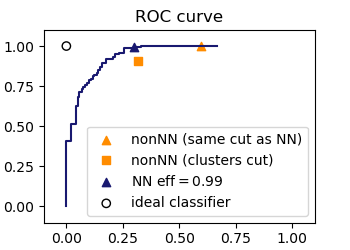

In [37]:
# ROC curve on validation dataset

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 5:	return True
	return False

def isLabeledGoodClustering(event):
	# Length of largest cluster
	clusters = Cluster.clusterise(event)
	ok_counter = 0
	for cluster in clusters:
		if cluster.pad_length >= 4:	return True
		if cluster.pad_length >= 3:	
			ok_counter += 1
			if ok_counter == 2:	return True
	return False


thresholds = numpy.concatenate( [numpy.linspace(0.0000001/60,0.00001,100), numpy.linspace(0.00001,0.99,100), numpy.linspace(0.99,1,70)] )
n = thresholds.shape[0]

# Count nonNN eff and FP and also NN eff and FP for individual classification thresholds
num_tracks, found_nonNN, _, FP_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)
num_found_nonNN , num_FP_nonNN= len(found_nonNN), len(FP_nonNN)
nums_found_NN, nums_FP_NN = [0]*n, [0]*n
for i in range(n):
	if i % 10 == 0:	print(i, "/", n)
	classified_events = numpy.where(X17_reconstructions > thresholds[i], 1, 0)
	_, found, _, FP = compareGroundTruth(classified_events, isLabeledGood, skip_calibration=True)
	nums_found_NN[i], nums_FP_NN[i] = len(found), len(FP)
	#print(len(found)/180)

NN_FPRs = [fp / (num_tracks + fp) for fp in nums_FP_NN]
nonNN_FPR = num_FP_nonNN / (num_tracks + num_FP_nonNN)
NN_effs = [num_found / num_tracks for num_found in nums_found_NN]
nonNN_eff = num_found_nonNN / num_tracks

_, found_nonNN_clustering, _, FP_nonNN_clustering = compareGroundTruth(X17_nonNN, isLabeledGoodClustering, skip_calibration=True)
num_found_nonNN_clustering , num_FP_nonNN_clustering = len(found_nonNN_clustering), len(FP_nonNN_clustering)
nonNN_FPR_clustering = num_FP_nonNN_clustering / (num_tracks + num_FP_nonNN_clustering)
nonNN_eff_clustering = num_found_nonNN_clustering / num_tracks

classified_events = numpy.where(X17_reconstructions > 0.21, 1, 0)
_, found, _, FP = compareGroundTruth(classified_events, isLabeledGood, skip_calibration=True)
num_found_NN_specific, num_FP_NN_specific = len(found), len(FP)
NN_FPR_specific = num_FP_NN_specific / (num_tracks + num_FP_NN_specific)
NN_eff_specific = num_found_NN_specific / num_tracks

# Threshold closest to (0,1)
def distance(fp, eff):
	return fp**2 + (eff-1)**2	#L2

optimal_threshold, best_dist, optimal_index_geo = -1, numpy.infty, -1
for j in range(n):
	dist = distance(NN_FPRs[j], NN_effs[j])
	if dist < best_dist:
		optimal_index_geo = j
		optimal_threshold = thresholds[j]
		best_dist = dist
print("Smallest L2 distance threshold:", optimal_threshold, "(point (FPR, eff) = (" + str(NN_FPRs[optimal_index_geo]) + ", " + str(NN_effs[optimal_index_geo]) + ") )")

# First threshold with efficiency one
optimal_threshold = -1
optimal_index_eff = -1
minimal_eff = 0.99
for j in range(n-1,-1,-1):
	if NN_effs[j] >= minimal_eff:
		optimal_threshold = thresholds[j]
		optimal_index_eff = j
		break
print("Best eff=1 threshold:", optimal_threshold, "(point (FPR, eff) = (" + str(NN_FPRs[optimal_index_eff]) + ", " + str(NN_effs[optimal_index_eff]) + ") )")


# Plot ROC
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(1)
fig.set_size_inches(3.5, 2.5)
ax.plot(NN_FPRs, NN_effs, color="midnightblue", drawstyle="steps-post")
ax.scatter([nonNN_FPR], [nonNN_eff], marker="^" , color="darkorange", label="nonNN (same cut as NN)")
ax.scatter([nonNN_FPR_clustering], [nonNN_eff_clustering], marker="s" , color="darkorange", label="nonNN (clusters cut)")
ax.scatter([NN_FPRs[optimal_index_eff]], [NN_effs[optimal_index_eff]], marker="^", color="midnightblue", label="NN eff$= 0.99$")
ax.scatter([0], [1], marker="o", facecolors="none", color="black", label="ideal classifier")
ax.set_xlabel("false positive rate")
ax.set_ylabel("efficiency")
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_title("ROC curve")
ax.legend()
matplotlib.pyplot.show()



In [38]:
# Lost event?
_, found, _, FP = compareGroundTruth(numpy.where(X17_reconstructions > 0.42, 1, 0), isLabeledGood, skip_calibration=True)
GT = getGroundTruthList(True)
lost = []
for i in range(541):
	if GT[i] == 1 and i not in found:
		lost.append(i)
print(lost)

[77]


In [ ]:
# ROC export on validation dataset

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 5:	return True
	return False

def isLabeledGoodClustering(event):
	# Length of largest cluster
	clusters = Cluster.clusterise(event)
	ok_counter = 0
	for cluster in clusters:
		if cluster.pad_length >= 4:	return True
		if cluster.pad_length >= 3:	
			ok_counter += 1
			if ok_counter == 2:	return True
	return False


thresholds = numpy.concatenate( [numpy.linspace(0.0000001/60,0.00001,100), numpy.linspace(0.00001,0.99,100), numpy.linspace(0.99,1,70)] )
n = thresholds.shape[0]

# Count nonNN eff and FP and also NN eff and FP for individual classification thresholds
num_tracks, found_nonNN, _, FP_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)
num_found_nonNN , num_FP_nonNN= len(found_nonNN), len(FP_nonNN)
nums_found_NN, nums_FP_NN = [0]*n, [0]*n
for i in range(n):
	if i % 10 == 0:	print(i, "/", n)
	classified_events = numpy.where(X17_reconstructions > thresholds[i], 1, 0)
	_, found, _, FP = compareGroundTruth(classified_events, isLabeledGood, skip_calibration=True)
	nums_found_NN[i], nums_FP_NN[i] = len(found), len(FP)
	#print(len(found)/180)

NN_FPRs = [fp / (num_tracks + fp) for fp in nums_FP_NN]
NN_effs = [num_found / num_tracks for num_found in nums_found_NN]

f = open("ROC.txt", "w")
for i in range(n):
	f.write(str(thresholds[i]) + " " + str(NN_effs[i]) + " " + str(NN_FPRs[i]) + "\n")
f.close()

0 / 270
10 / 270
20 / 270
30 / 270
40 / 270
50 / 270
60 / 270
70 / 270
80 / 270
90 / 270
100 / 270
110 / 270
120 / 270
130 / 270
140 / 270
150 / 270
160 / 270
170 / 270
180 / 270
190 / 270
200 / 270
210 / 270
220 / 270
230 / 270
240 / 270
250 / 270
260 / 270


In [40]:
# Flagging intersections

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 5:	return True
	return False

threshold = 0.42

N = X17_reconstructions.shape[0]
classified_events = numpy.where(X17_reconstructions > threshold, 1, 0)
num_tracks, found_tracks_NN, unfound_tracks_NN, false_positives_NN = compareGroundTruth(classified_events, isLabeledGood, skip_calibration=True)
_, found_tracks_nonNN, unfound_tracks_nonNN, false_positives_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)

def getIntersection(NN, nonNN, use_tracks):
	ls_NN = found_tracks_NN if use_tracks else false_positives_NN
	ls_nonNN = found_tracks_nonNN if use_tracks else false_positives_nonNN
	return [j for j in range(N) if ( (NN and j in ls_NN) or (not NN and j not in ls_NN) )
			and ( (nonNN and j in ls_nonNN) or (not nonNN and j not in ls_nonNN) )]

print("NN & nonNN IN FOUND TRACKS:", len(getIntersection(True, True, True)))
print("NN & nonNN IN FPS:", len(getIntersection(True,True,False)))
print("NN & NOT nonNN IN FPS:", len(getIntersection(True,False,False)))
print("NOT NN & nonNN IN FPS:", len(getIntersection(False,True,False)))
print("NOT NN & NOT nonNN IN FOUND TRACKS:", len(getIntersection(False,False,True)))
print("NN & NOT nonNN IN FOUND TRACKS:", len(getIntersection(True,False,True)))
print("NOT NN & nonNN IN FOUND TRACKS:", len(getIntersection(False,True,True)))
print("NOT NN & NOT nonNN IN FPS:", len(getIntersection(False,False,False)))
print("Eff:",len(found_tracks_NN)/num_tracks)
print("FP:",len(false_positives_NN)/(len(false_positives_NN) + num_tracks))

NN & nonNN IN FOUND TRACKS: 179
NN & nonNN IN FPS: 77
NN & NOT nonNN IN FPS: 0
NOT NN & nonNN IN FPS: 189
NOT NN & NOT nonNN IN FOUND TRACKS: 361
NN & NOT nonNN IN FOUND TRACKS: 0
NOT NN & nonNN IN FOUND TRACKS: 1
NOT NN & NOT nonNN IN FPS: 275
Eff: 0.9944444444444445
FP: 0.29961089494163423


Tile number: 12
Ratio of tiles on line fit: 1.0
Average distance from line fit: 0.2904280975492664
Missing tiles: 30
Relative ration of outliers: 0.0


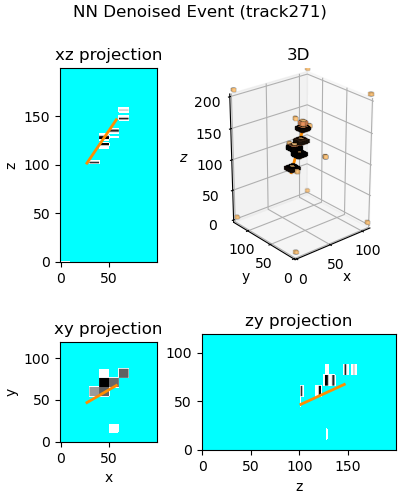

In [44]:
# Line fit analysis example
modelAPI.threshold = 0.42

index = numpy.random.choice(data_loader.nice_track_indices)
event = data_loader.getBatch(True,True)[index]
rec = modelAPI.evaluateSingleEvent(event)
result = modelAPI.classify(rec)
name = data_loader.getX17Names()[index]
in_temporal_space = False	# Whether fitting happens in (x,y,t) or (x,y,z)

#lin_fit = LinearFit( numpy.where(rec>1e-5, rec, 0), in_temporal_space, use_weights=True)
lin_fit = LinearFit( result, in_temporal_space, use_weights=False)

outliers = lin_fit.getOutliers()
mean_residuum = lin_fit.getMeanResiduum()
missing_tiles = lin_fit.getMissingTiles(event, in_temporal_space)

print("Tile number:", len(lin_fit.coords))
print("Ratio of tiles on line fit:", 1 - len(outliers)/len(lin_fit.coords))
print("Average distance from line fit:", mean_residuum)
print("Missing tiles:", len(missing_tiles))
print("Relative ration of outliers:", lin_fit.getRatioOutliers())

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

a, b = lin_fit.start, lin_fit.end
multiplies = (10, 6/5*10, (1 if in_temporal_space else 15))
for i in range(3):
	a[i], b[i] = multiplies[i]*a[i] - lin_fit.direction[i], multiplies[i]*b[i] + lin_fit.direction[i]

projs = {(0,0): (0,2),	(1,0): (0,1),	(1,1): (2,1)}

fig, ax = Plotting.plot2DAnd3D(rec, "NN Denoised Event (" + name + ")", elev=25, azimuth=-130)
ax[0,1].plot(*[(a[i], b[i]) for i in range(3)], color="darkorange", linewidth=2)
for proj in projs:
	k, l = projs[proj]
	ax[proj].plot((a[k], b[k]), (a[l], b[l]), color="darkorange", linewidth=2)

fig.set_size_inches(4,5)
matplotlib.pyplot.show()

In [45]:
# Linear analysis support functions

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 5:	return True
	return False

def getLinearlyFittableIndices(events :numpy.ndarray, outliers_threshold :float, in_temporal_space :bool = True):
	fittable_indices = []
	for i in range(events.shape[0]):
		event = events[i]
		
		if isLabeledGood(event):
			lin_fit = LinearFit(event, in_temporal_space)
			if lin_fit.getRatioOutliers() <= outliers_threshold:
				fittable_indices.append(i)
	return fittable_indices

def getMeanLinearVals(events :numpy.ndarray, noisy_events :numpy.ndarray, in_temporal_space :bool = True) -> tuple[float, float, float]:
	ratios_outliers = []
	total_residuum = 0
	total_tile_num = 0
	total_missing_tiles = 0
		
	for i in range(events.shape[0]):
		event, noisy_event = events[i], noisy_events[i]
		lin_fit = LinearFit(event, in_temporal_space)

		ratios_outliers.append( lin_fit.getRatioOutliers() )
		total_residuum += lin_fit.getTotalResiduum()
		total_tile_num += len(lin_fit.coords)
		total_missing_tiles += len( lin_fit.getMissingTiles(noisy_event, in_temporal_space=in_temporal_space) )
	
	return (sum(ratios_outliers) / (len(ratios_outliers) if len(ratios_outliers) != 0 else 1), total_residuum / (total_tile_num if total_tile_num != 0 else 1), 
		 total_missing_tiles / (events.shape[0] if events.shape[0] != 0 else 1))

/home/gajdoma6/UTEF/track_denoiser/classes/linearFitClass.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  t1, t2 = (a-mean[2]) / direction[2], (b-mean[2]) / direction[2]
/home/gajdoma6/UTEF/track_denoiser/classes/linearFitClass.py:26: RuntimeWarning: invalid value encountered in multiply
  return (mean + t1*direction, mean + t2*direction, mean, direction)
/home/gajdoma6/UTEF/track_denoiser/classes/linearFitClass.py:25: RuntimeWarning: invalid value encountered in double_scalars
  t1, t2 = (a-mean[2]) / direction[2], (b-mean[2]) / direction[2]


21659 21659 21659


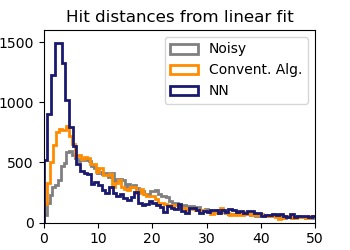

In [46]:
# Line fit analysis as histogram

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 5:	return True
	return False

modelAPI.threshold = 0.42
NN_classifications = modelAPI.classify(X17_reconstructions)
threshold_outliers = 0.2
in_temporal_space = False

N_events = numpy.shape(X17_noisy)[0]

distances_NN = []
distances_nonNN = []
distances_noisy = []
distances_noisy_NN = []
distances_noisy_nonNN = []

NN_squared_total_residua = []

for i in range(N_events):
	NN_sum_squares = 0
	noisy_sum_squares = 0

	NN_event = NN_classifications[i]
	nonNN_event = X17_nonNN[i]
	noisy_event = X17_noisy[i]

	if isLabeledGood(NN_event) and isLabeledGood(nonNN_event) and isLabeledGood(noisy_event):	# Look only at events where all three fits exist
		# NN
		lin_fit = LinearFit(NN_event, in_temporal_space)
		for coord in lin_fit.coords:
			distances_NN.append( 10*lin_fit.getResiduum(coord))	# cm -> mm
		
		# noisy with NN fit
		noisy_coords = LinearFit.eventToCoords(X17_noisy[i], in_temporal_space=False)
		for coord in noisy_coords:
			distances_noisy_NN.append( 10*lin_fit.getResiduum(coord))
			
			NN_sum_squares += lin_fit.getResiduum(coord)**2
	
		# nonNN
		lin_fit = LinearFit(nonNN_event, in_temporal_space)
		for coord in lin_fit.coords:
			distances_nonNN.append( 10*lin_fit.getResiduum(coord))

		# noisy with nonNN fit
		noisy_coords = LinearFit.eventToCoords(X17_noisy[i], in_temporal_space=False)
		for coord in noisy_coords:
			distances_noisy_nonNN.append( 10*lin_fit.getResiduum(coord))
	
	# noisy with its own fit
		lin_fit = LinearFit(noisy_event, in_temporal_space)
		for coord in lin_fit.coords:
			distances_noisy.append( 10*lin_fit.getResiduum(coord))
			
			noisy_sum_squares += lin_fit.getResiduum(coord)**2

print(len(distances_noisy), len(distances_noisy_nonNN), len(distances_noisy_NN))

# Plot the result
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(1)
fig.set_size_inches(3.5, 2.5)

ax.hist(distances_noisy, bins=200, density=False, label="Noisy", histtype="step", color="gray", linewidth=2)
ax.hist(distances_noisy_nonNN, bins=200, density=False, label="Convent. Alg.", color="darkorange", histtype="step", linewidth=2)
ax.hist(distances_noisy_NN, bins=200, density=False, label="NN", color="midnightblue", histtype="step", linewidth=2)

ax.set_ylabel("hit count")
ax.set_title("Hit distances from linear fit")
ax.set_xlim(0,50)
ax.set_ylim(0,1600)
ax.set_xlabel("distance (mm)")
ax.legend()
matplotlib.pyplot.show()


/tmp/ipykernel_432/2851948632.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  tau = (boundaries[k][j] - A[k]) / v[k]
/tmp/ipykernel_432/2851948632.py:52: RuntimeWarning: invalid value encountered in double_scalars
  intersections.append( [A[i] + tau*v[i] for i in range(3)] )
/tmp/ipykernel_432/2851948632.py:51: RuntimeWarning: invalid value encountered in double_scalars
  tau = (boundaries[k][j] - A[k]) / v[k]


[   0  200  400  600  800 1000 1200 1400 1600 1800 2000 2200 2400 2600
 2800 3000 3200 3400 3600 3800 4000]


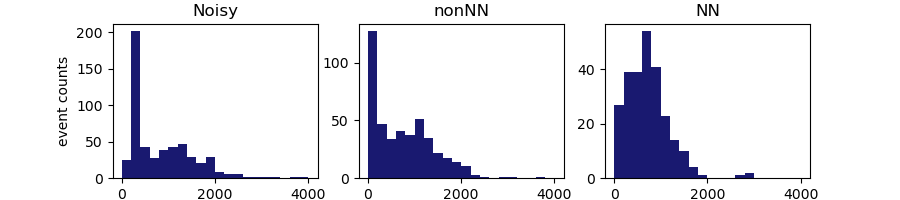

In [47]:
# Four reconstruction energy histograms

modelAPI.threshold = 0.42
dist_threshold = 1000000000	# cm, can be set to filter hits that are too far from the fit
in_temporal_space = False

X17_classified = modelAPI.classify(X17_reconstructions)
boundaries = [[0,10], [0,12*5/6], [80/15, 200/15]]

def getTotalEnergyMax(event, lin_fit, dist_threshold):
	close_pads = {}
	xs, ys, zs = numpy.nonzero(event)
	coords = ( list(xs), list(ys), list(zs) )
	coords = list(zip(*coords))
	for coord in coords:
		x_pad, y_pad = coord[0], coord[1]
		x, y, z = x_pad, 5/6 * y_pad, 1/15 * coord[2]
		if (x_pad,y_pad) not in close_pads and lin_fit.getResiduum((x,y,z)) <= dist_threshold:	#collinear hit
			close_pads[(x_pad,y_pad)] = numpy.max( event[x_pad, y_pad,:] )
	return sum( close_pads[k] for k in close_pads )


def getTotalEnergyIntegral(event, lin_fit, dist_threshold):
	xs, ys, zs = numpy.nonzero(event)
	E = 0
	coords = ( list(xs), list(ys), list(zs) )
	coords = list(zip(*coords))
	for coord in coords:
		x_pad, y_pad = coord[0], coord[1]
		x, y, z = x_pad, 5/6 * y_pad, 1/15 * coord[2]
		if  lin_fit.getResiduum((x,y,z)) <= dist_threshold:	#collinear hit
			E += event[coord]
	return E


def nonemptyCriterion(event):
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 5:	return True
	return False


def getLength(lin_fit, boundaries):
	def getBoundariesIntersections(v, A):
		intersections = []
		for k in range(3):
			for j in range(2):	# Plane defined as coordinate_k == value_k,j
				tau = (boundaries[k][j] - A[k]) / v[k]
				intersections.append( [A[i] + tau*v[i] for i in range(3)] )
		return intersections

	def testLocation(P):
		eps = 1e-3
		for i in range(3):
			if not (boundaries[i][0]-eps <= P[i] <= boundaries[i][1]+eps):	return False
		return True

	v, A = lin_fit.direction, lin_fit.mean
	intersections = getBoundariesIntersections(v, A)
	intersections = [P for P in intersections if testLocation(P)]	# 2 active volume intersections
	N = len(intersections)
	if N < 2:
		print("WARNING: Incorrect number of intersections found")
		return None
	else:	# It can happen that len(intersections) > 2 because the line passes through edge/vertex
		Ls = []
		for k in range(N):
			for l in range(k+1, N):
				Ls.append( numpy.sqrt( sum( (intersections[k][i] - intersections[l][i])**2 for i in range(3) ) ) )
		return max(Ls)


def getELs(decision_events, energy_events, dist_threshold, boundaries):
	n = decision_events.shape[0]
	E_Ls = [None]*n
	
	for i in range(n):
		decision_event, energy_event = decision_events[i], energy_events[i]
		if nonemptyCriterion(decision_event):
			lin_fit = LinearFit(decision_event, in_temporal_space=False)
			L = getLength(lin_fit, boundaries)
			if L != None:
				#print(L)
				E = getTotalEnergyIntegral(energy_event, lin_fit, dist_threshold)
				E_Ls[i] = E/L
	return E_Ls


E_L_noisy = getELs(X17_noisy_with_E, X17_noisy_with_E, dist_threshold, boundaries)
E_L_nonNN = getELs(X17_nonNN, numpy.where(X17_nonNN>0, X17_noisy_with_E, 0), dist_threshold, boundaries)
E_L_NN = getELs(X17_classified, numpy.where(X17_classified>0, X17_noisy_with_E, 0), dist_threshold, boundaries)

E_L_nonNN_all = getELs(X17_nonNN, X17_noisy_with_E, dist_threshold, boundaries)
E_L_NN_all = getELs(X17_classified, X17_noisy_with_E, dist_threshold, boundaries)

E_L_noisy = [el for el in E_L_noisy if el is not None]
E_L_nonNN = [el for el in E_L_nonNN if el is not None]
E_L_NN = [el for el in E_L_NN if el is not None]
E_L_nonNN_all = [el for el in E_L_nonNN_all if el is not None]
E_L_NN_all = [el for el in E_L_NN_all if el is not None]

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(1,3)
fig.set_size_inches(9, 2)

#size = 45
#bins = numpy.arange(0, 800+size, size)
size = 200
bins = numpy.arange(0, 4000+size, size)
print(bins)
ax[0].hist(E_L_noisy, bins=bins, histtype="stepfilled", color="midnightblue", density=False)
ax[1].hist(E_L_nonNN, bins=bins, histtype="stepfilled", color="midnightblue", density=False)
ax[2].hist(E_L_NN, bins=bins, histtype="stepfilled", color="midnightblue", density=False)

ax[0].set_title("Noisy")
ax[1].set_title("nonNN")
ax[2].set_title("NN")

ax[0].set_ylabel("event counts")
for i in range(3):
	#ax[i].set_xlim(0,800)
	ax[i].set_xlabel("E/L")

matplotlib.pyplot.show()